In [1]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
G = nx.read_edgelist('./vidal_tsv')

# Visualization

In [3]:
# remove self-loops
self_loops = [(u, v) for u, v in G.edges() if u == v]
G.remove_edges_from(self_loops)

nx.convert_node_labels_to_integers(G)

In [20]:
# drawing function
def draw(G:nx.Graph, k=0.2, node_size=20, width=0.2, file_name='example.png', **kwargs):
    plt.figure(figsize=(25, 25)) 

    options = {
        "node_size": node_size, 
        "linewidths": 0.2, 
        "width": width,
        **kwargs,
    }
    pos = nx.spring_layout(G, k=k,seed=42)

    nx.draw_networkx(G, pos=pos, with_labels=False, **options)
    plt.savefig(file_name)
    plt.show()

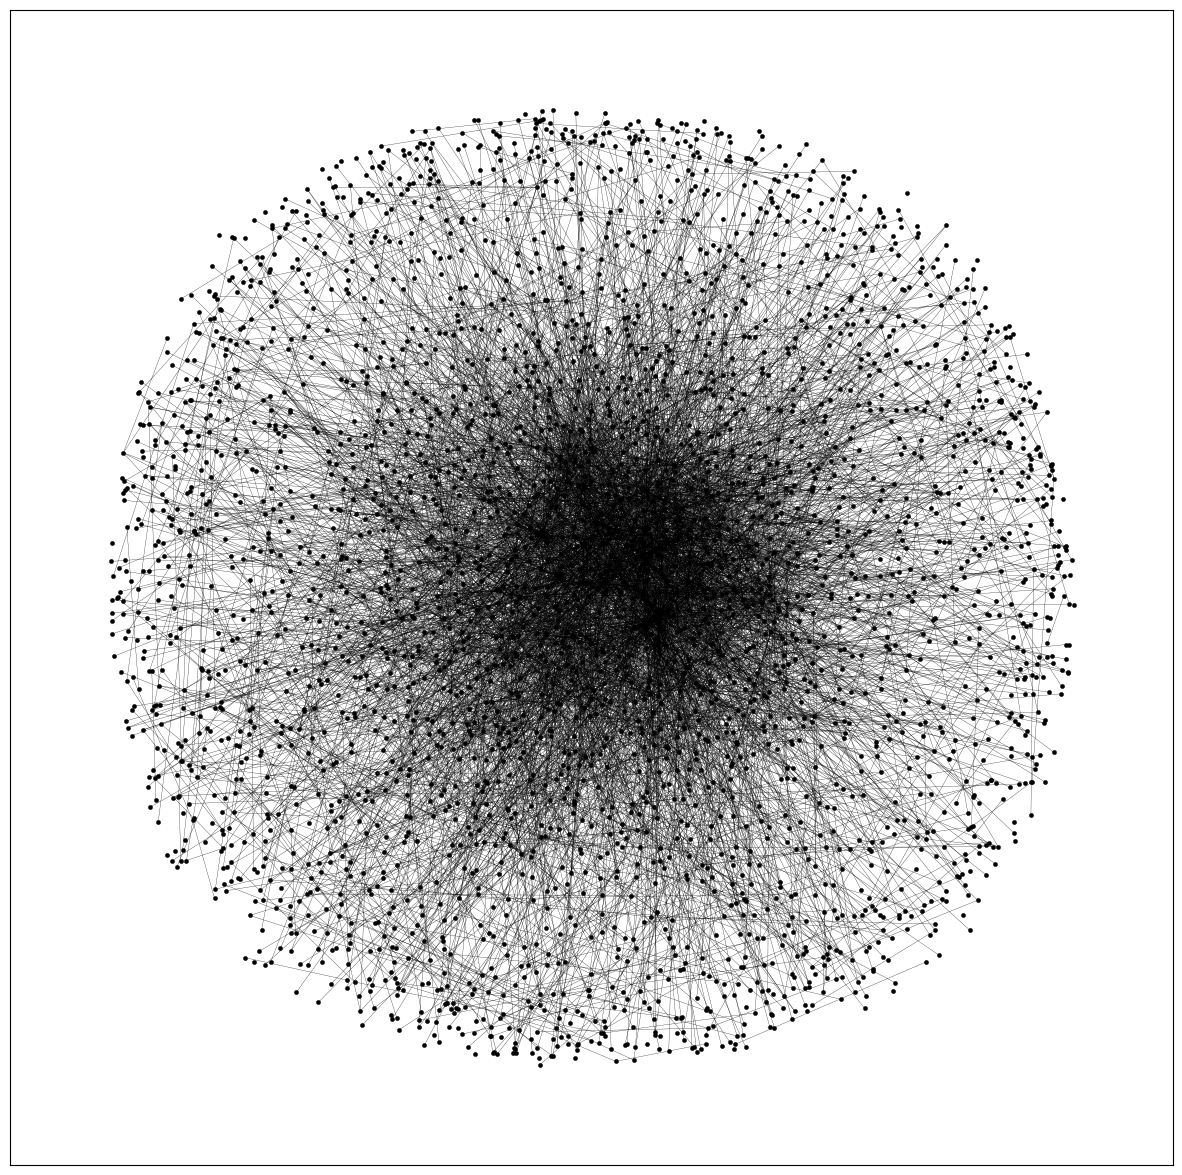

In [8]:
draw(G, node_color='black')

⬆️ Obviously there's a big CC in the middle and a bunch of isolated points on the periphery, so i decide to remove these peripheral points first.

In [5]:
# Extract the Largest CC

connected_components = list(nx.connected_components(G))
largest_connected_component = max(connected_components, key=len)
G_lcc = G.subgraph(largest_connected_component)

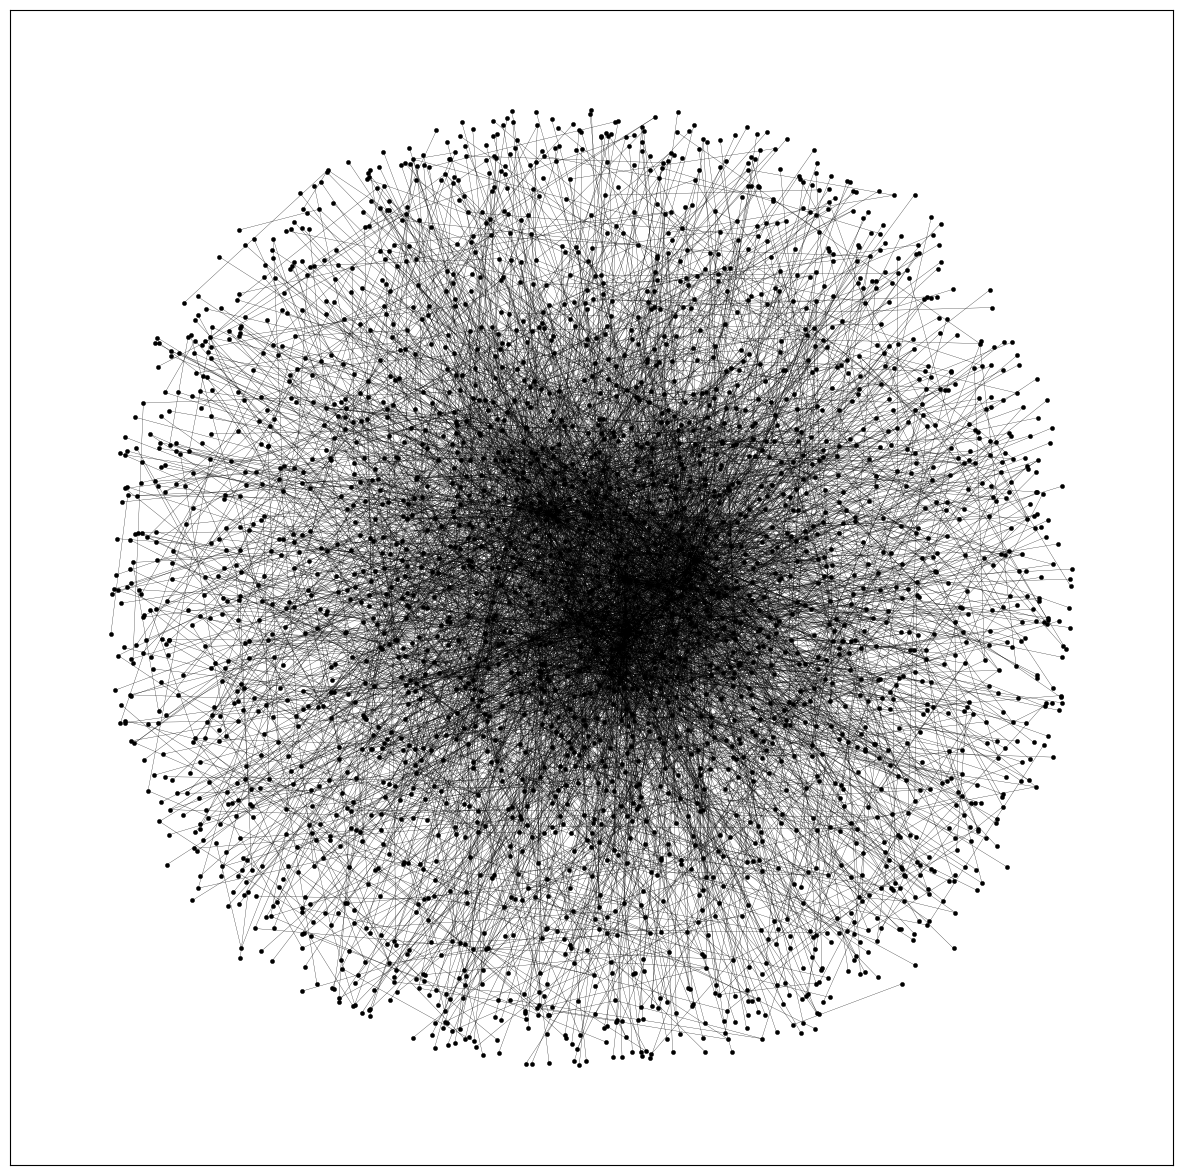

In [10]:
draw(G_lcc, node_color='black')

# Spectral Clustering

Some basic equations about spectral clustering and the algorithms behind it.

1. Compute $L = D - A$ where $D$ is the degree matrix of the graph and $A$ is the adjacency matrix.
2. Compute the eigenvalues and eigenvectors of $L$.
3. For the first $k$ smallest eigenvectors of $L$, $\{u_1,...,u_k\}$, build the matrix $U \in \mathbb{R}^{n \times k}$ which contains the vectors as columns.
4. For $i = 1,...,n$, let $y_i \in \mathbb{R}^k$ be the $i-$th row of $U$.
5. Use $k-$means algorithm to cluster $y_1,...,y_n$ into $C_1,...,C_k$. 
6. Output clusters $A_1,...,A_k$ where $A_i = \{j|y_j \in C_i\}$.

Note: it is better to use $L_{rw} = D^{-1}L$, where $D$ is the degree matrix of the graph and $L$ is the laplacian matrix.

In [9]:
# Eigendecomposition
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from scipy import sparse

# nx.adjacency_matrix() will return a 'scipy.sparse' array
L = nx.laplacian_matrix(G_lcc)
nodes = list(G_lcc.nodes())
degrees = np.array([G_lcc.degree(key) for key in nodes])
degrees_inv = 1./degrees
D = sparse.csr_matrix(np.diag(degrees))
D_inv = sparse.csr_matrix(np.diag(degrees_inv))
L_rw = D_inv@L
L = L.astype('float64')
L_rw = L_rw.astype('float64')

<class 'networkx.utils.decorators.argmap'> compilation 25:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-package

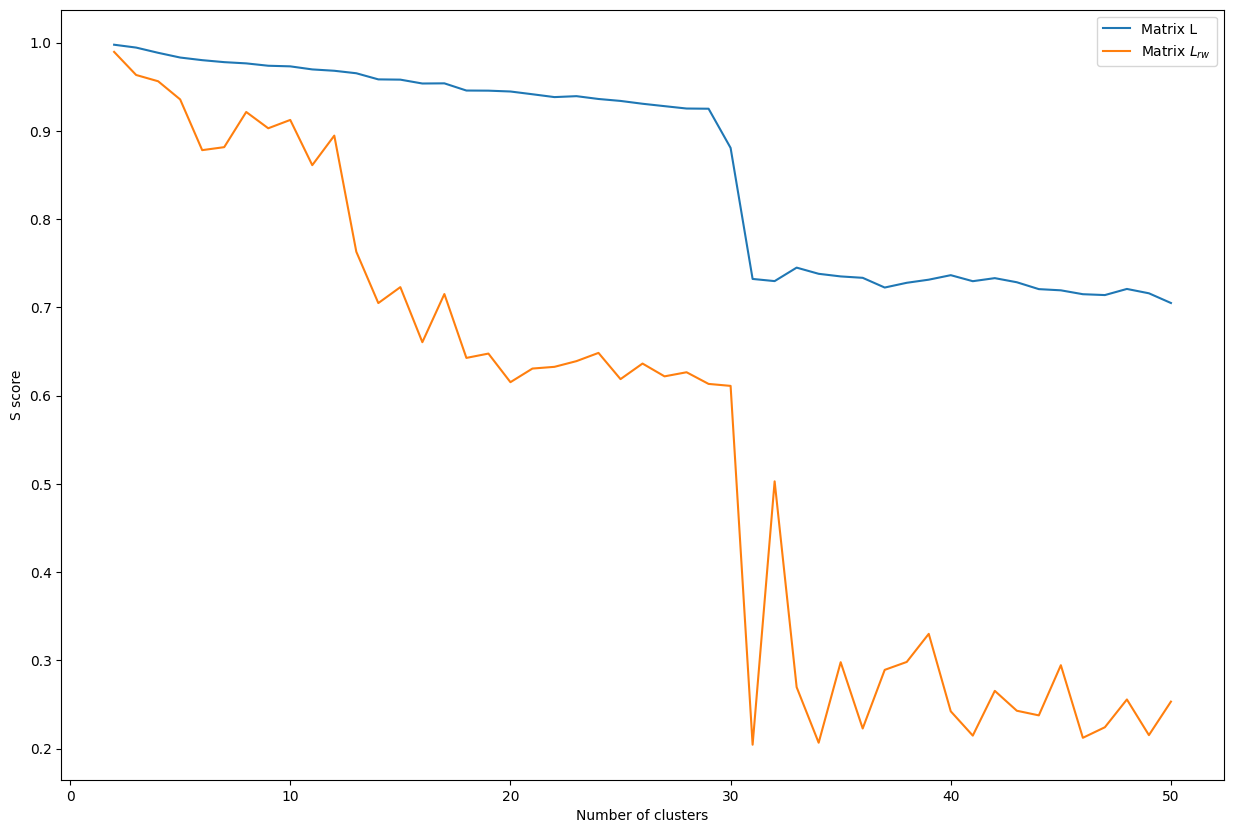

In [11]:
from sklearn.cluster import spectral_clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

L = L.astype('float64')
L_rw = L_rw.astype('float64')
s_score_L_list = []
s_score_L_rw_list = []
K = np.arange(2,50+1,1)


for k in K:
    eigenvalues, eigenvectors = eigsh(L, k = k, which = 'SM')
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(eigenvectors)
    labels = kmeans.labels_
    counts = np.bincount(labels)
    s_score_L = silhouette_score(eigenvectors, labels, metric = 'euclidean')
    s_score_L_list.append(s_score_L)
    
for k in K:
    eigenvalues, eigenvectors = eigsh(L_rw, k = k, which = 'SM')
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(eigenvectors)
    labels = kmeans.labels_
    counts = np.bincount(labels)
    s_score_L_rw = silhouette_score(eigenvectors, labels, metric = 'euclidean')
    s_score_L_rw_list.append(s_score_L_rw)

plt.figure(figsize = (15,10))
plt.plot(K, s_score_L_list, label = 'Matrix L')
plt.plot(K, s_score_L_rw_list, label = 'Matrix $L_{rw}$')
plt.xlabel('Number of clusters')
plt.ylabel('S score')
plt.legend()
plt.savefig('s_scores.png')
plt.show()



/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 2 3 4]


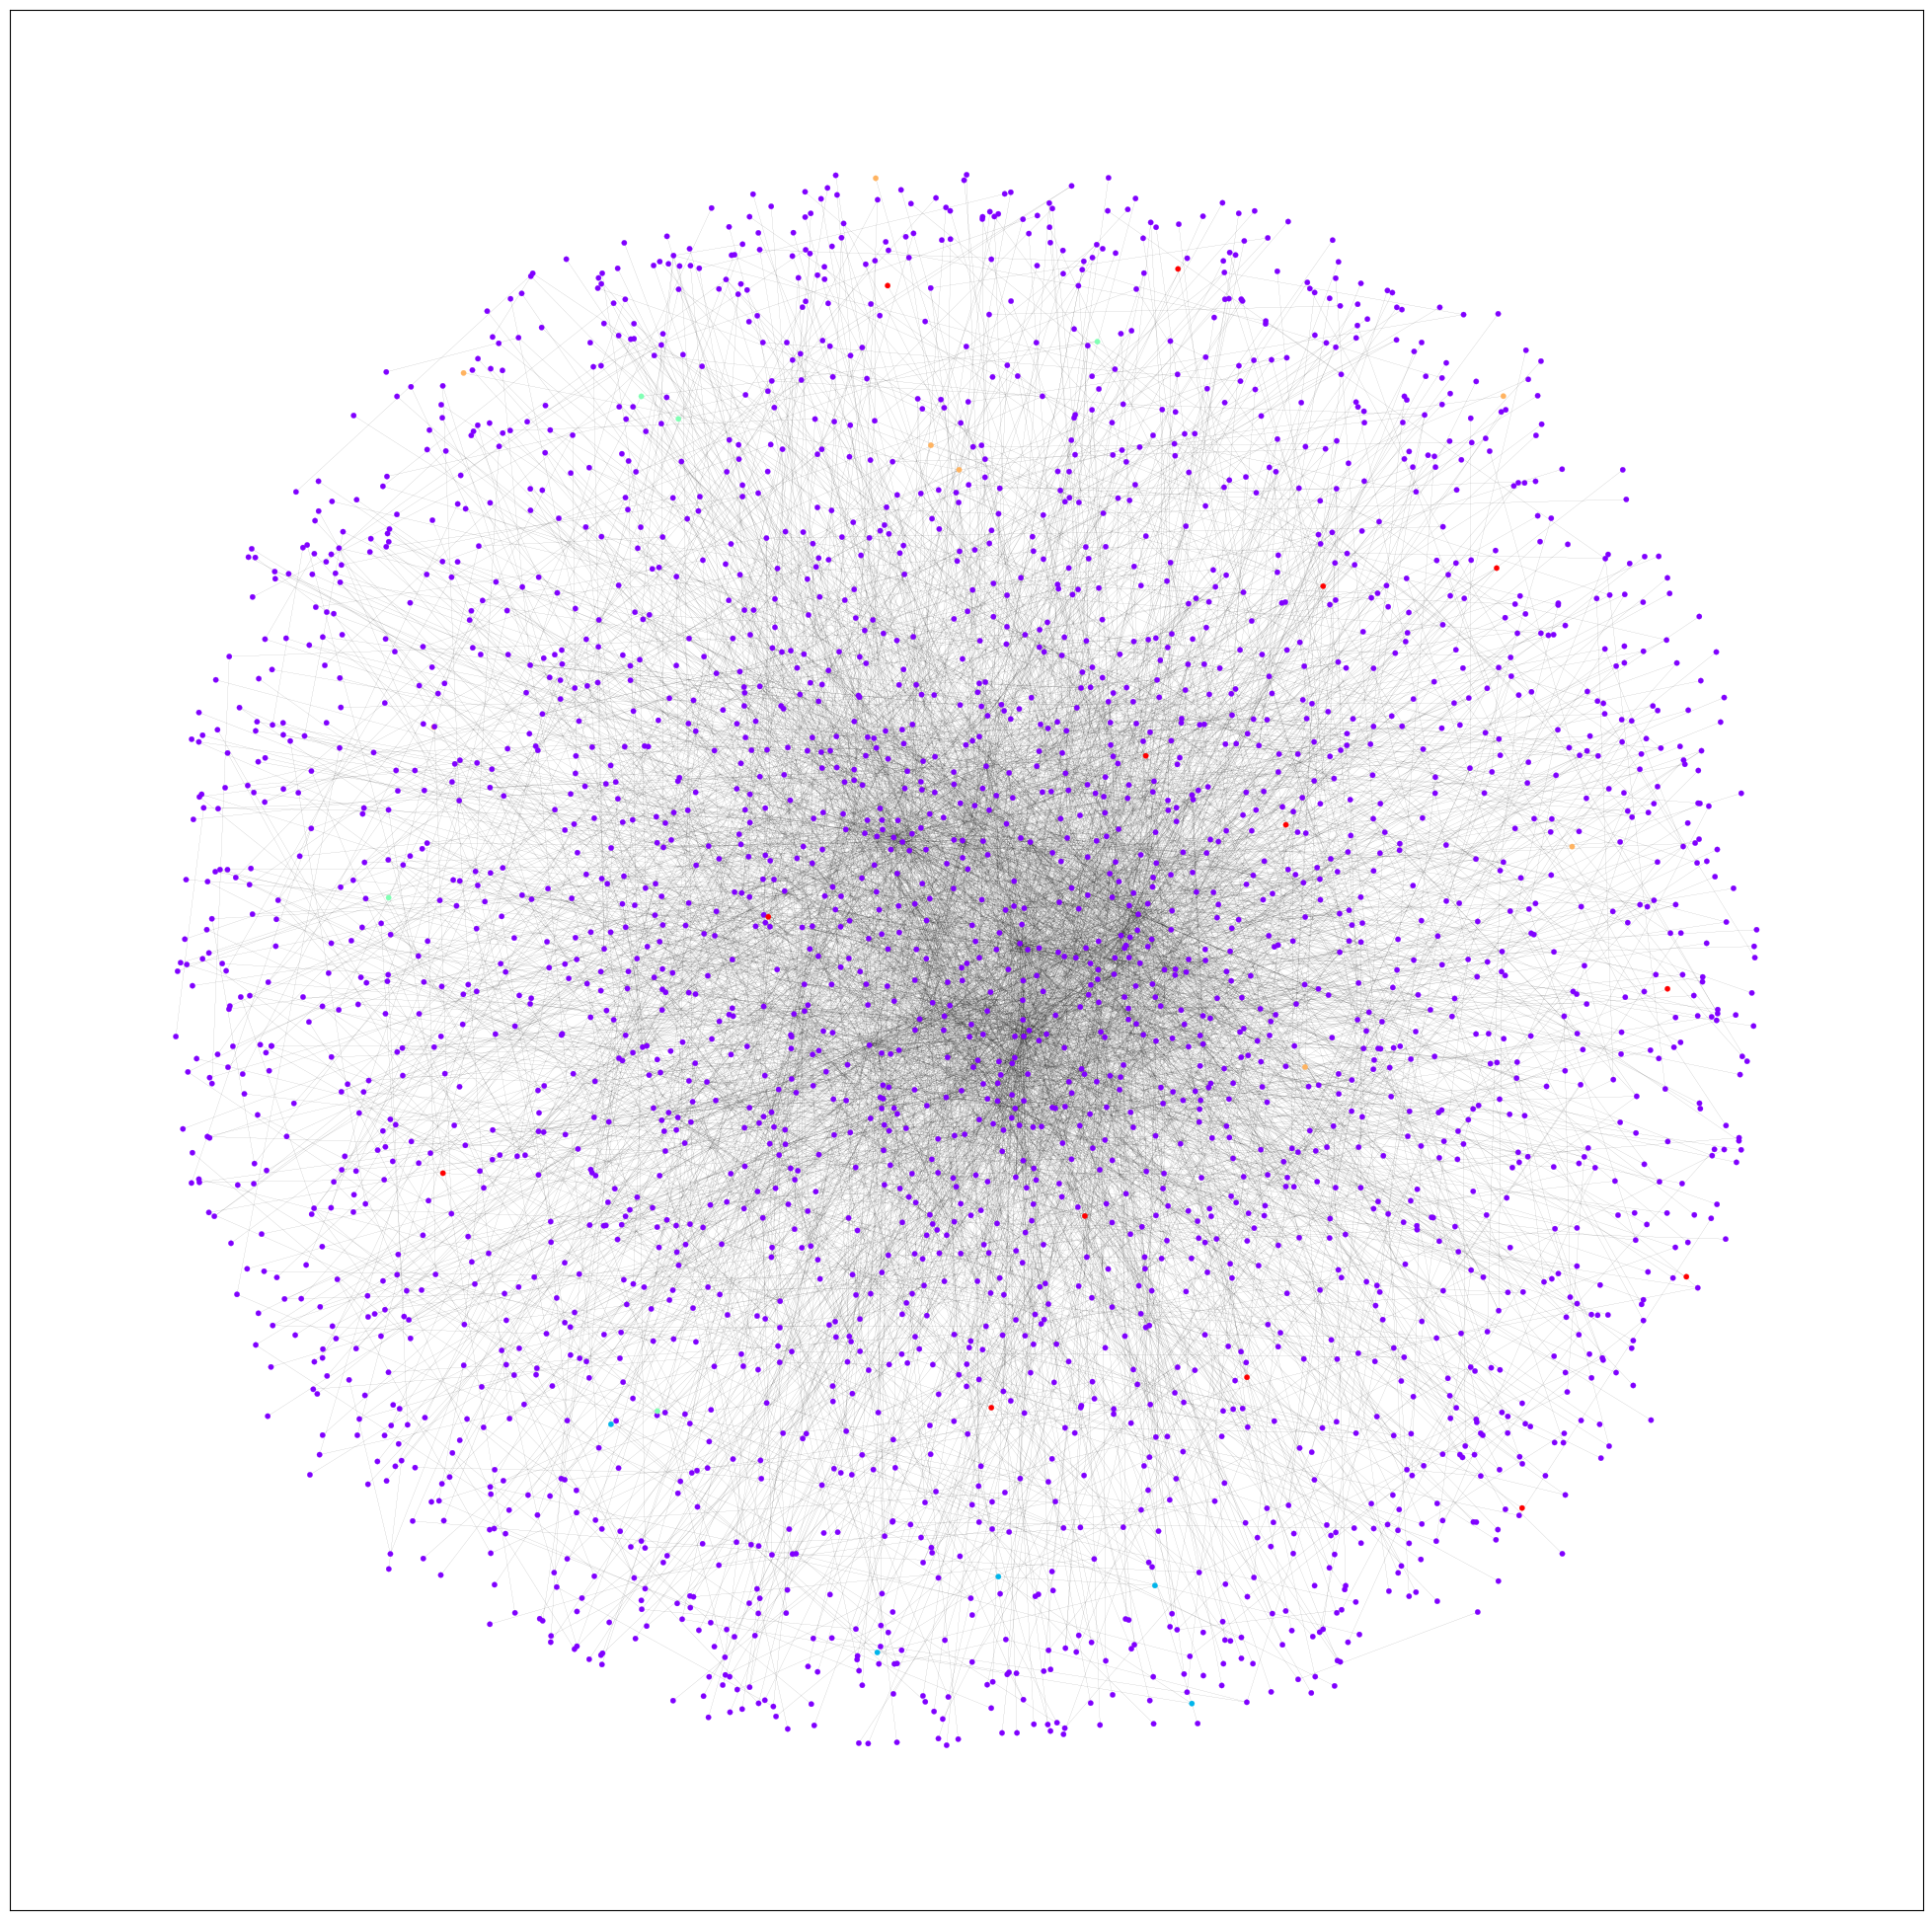

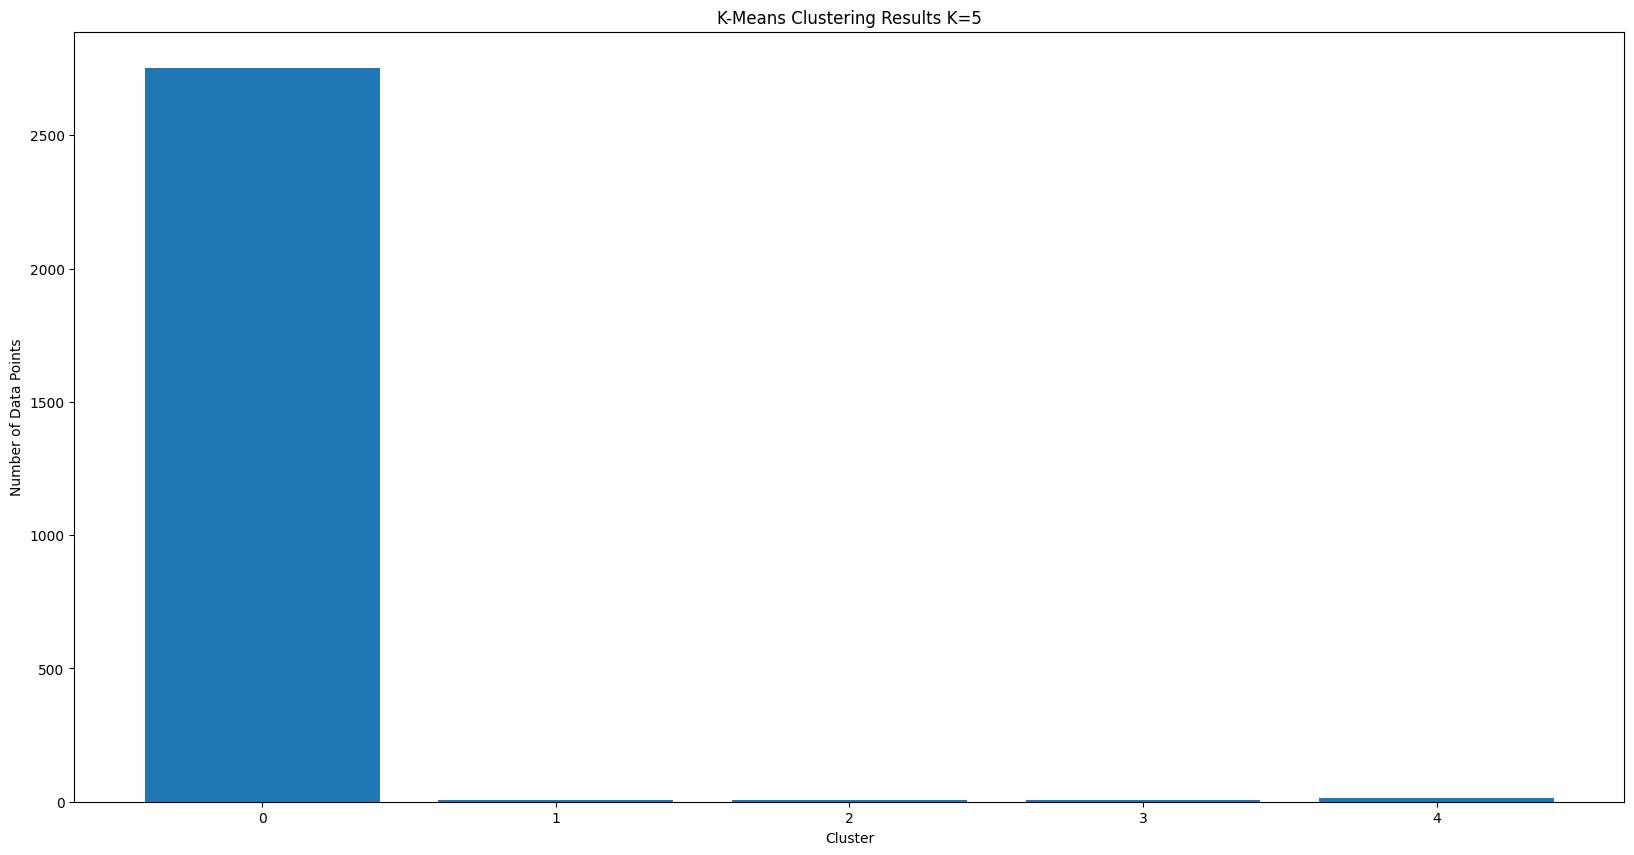

In [37]:
from matplotlib.pyplot import cm
from sklearn.cluster import spectral_clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = 5

def test(K):

    eigenvalues, eigenvectors = eigsh(L, k = K, which = 'SM')
    eigenvalues, eigenvectors = eigsh(L_rw, k = K, which = 'SM')
    kmeans = KMeans(n_clusters = K, random_state = 0).fit(eigenvectors)
    labels = kmeans.labels_
    counts = np.bincount(labels)
    print(np.unique(labels))

    # color_map = {
    #     0: 'magenta',
    #     1: 'cyan',
    #     2: 'orange',
    #     3: 'green',
    #     4: 'crimson'
    # }

    color = cm.rainbow(np.linspace(0, 1, K))

    color_list = [color[label] for label in labels]
    draw(G_lcc, width=0.05, node_size=15,  node_color=color_list, file_name='community-'+str(K)+'.png')

    cluster_counts = np.bincount(labels)
    if K < 75:
        plt.figure(figsize = (20,10))
    else:
        plt.figure(figsize = (30,10))
    plt.bar(range(K), cluster_counts, tick_label=range(K))

    # Add labels and title
    plt.xlabel("Cluster")
    plt.ylabel("Number of Data Points")
    plt.title("K-Means Clustering Results K="+str(K))

    # Show the plot
    plt.savefig('community_bin_'+str(K)+'.png')
    plt.show()

K_list = [3,4,5,7,10,15,20,30,50,75,100,150]

test(K)

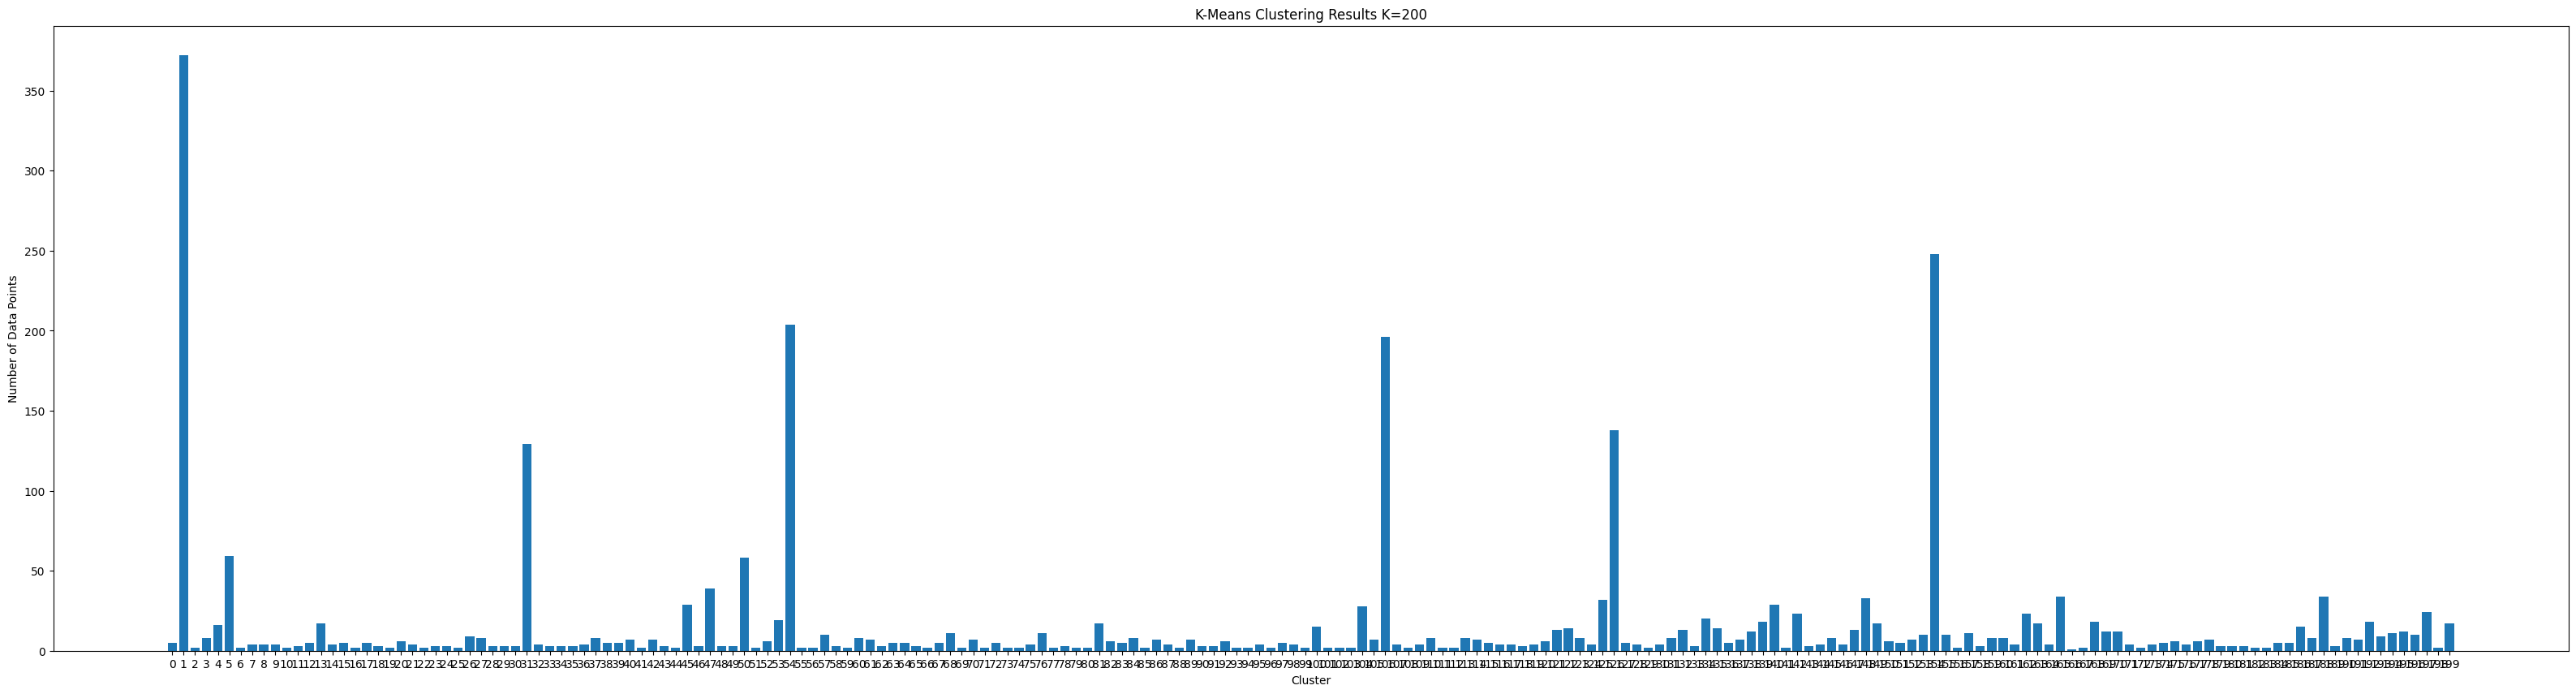

In [32]:
cluster_counts = np.bincount(labels)
plt.figure(figsize = (40,10))
plt.bar(range(K), cluster_counts, tick_label=range(K))

# Add labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.title("K-Means Clustering Results K="+str(K))

# Show the plot
plt.savefig('community_bin_'+str(K)+'.png')
plt.show()

In [ ]:
node_size=0